## Multilayer fully-connected network

Try with neural networks. First, implement a multilayer fully-connected network **using the OverFeat features** in a "Multilayer fully-connected network.ipynb" notebook.

In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random

%matplotlib inline

# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())

#let's take a look at the keys
print('Data loaded')
print('It is a dictionary with keys:', list(cifar4.keys()))

Data loaded
It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
# Create X/y arrays
X = cifar4['overfeat']
y = cifar4['labels']

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)

X: (5000, 4096) float32
y: (5000,) int64


**Q:** Split the 5000 labeled data points from "cifar4-train.npz" into train, validation and test sets with respectively 3200, 800 and 1000 data points.

In [3]:
# Split data into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, train_size=4000, test_size=1000, stratify = y, random_state=0)

In [4]:
#let's make sure of the uniform distribution of the data in the train set
pd.value_counts(y_tr, normalize = 'True')

3    0.25
1    0.25
2    0.25
0    0.25
dtype: float64

In [5]:
# split the train set again into validation and train sets
X_trval, X_val, y_trval, y_val = train_test_split(
    X_tr, y_tr, train_size=3200, test_size=800, stratify = y_tr, random_state=0)

In [6]:
#let's make sure of the uniform distribution of the data in the validation set
pd.value_counts(y_val, normalize = 'True')

3    0.25
2    0.25
1    0.25
0    0.25
dtype: float64

In [7]:
#let's standardize the data
scaler = StandardScaler()
X_trval = scaler.fit_transform(X_trval)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)

**Implement the following architecture:**
    - Input layer with the 4,096 OverFeat features
    - Hidden layer with 64 hidden units and ReLU activation
    - Output layer with 4 units (the four logits)
    
Add **dropout** to the input and hidden units with a rate of 0.5, and the **L2 regularization term** to the cross-entropy loss to penalize large values in the hidden and output weight matrices **W1, W2**. To achieve this, you can use the *l2_loss()* function from the *tf.nn* module and create an **alpha** placeholder to control the regularization strength.

In [8]:
# Create new graph
graph = tf.Graph()

with graph.as_default():
    
    training = tf.placeholder(dtype = tf.bool) # Create training placeholder
    
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096])
    X = tf.layers.dropout(X, rate = 0.5, seed = 0, training = training)
    y = tf.placeholder(dtype=tf.int64, shape=[None])
    
    # Hidden layer with 64 units
    hidden = tf.layers.dense(
        X, 64, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    # Apply dropout
    hidden = tf.layers.dropout(hidden, rate = 0.5, seed = 0, training = training)
    
    # Output layer
    logits = tf.layers.dense(
        hidden, 4, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    
    # Get weights of the hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
    
    # Get weights of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        
    # Loss fuction: mean cross-entropy with L2 regularization
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    l2_term_1 = tf.nn.l2_loss(W1) #L2 term for W1
    l2_term_2 = tf.nn.l2_loss(W2) #L2 term for W2
    alpha = tf.placeholder(dtype = tf.float32) #Regularization strength
    loss = mean_ce + alpha * (l2_term_1 + l2_term_2) # define loss function
    
    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(loss)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int64)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

**Q:** Train the network using **small random batches** of data from the train set, and save its accuracy on the validation set. Plot the results.

In [9]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

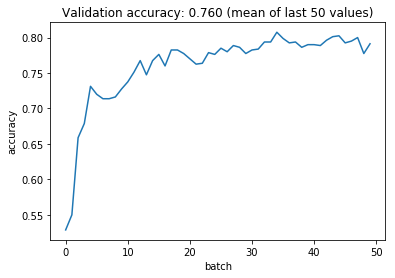

In [10]:
# Validation accuracy for batch visualization
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Get batches of data
    for X_batch, y_batch in get_batches(X_trval, y_trval, 64):
        # Run training and evaluate accuracy
        _, acc_value = sess.run([train_op, accuracy], feed_dict={
            X: X_batch,
            y: y_batch,
            lr: 0.05, # Learning rate
            alpha : 0.75,
            training: True
            })
        
        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_val,
            y: y_val,
            training: False
            })
        valid_acc_values.append(valid_acc)

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean of last 50 values)'. format(np.mean(valid_acc_values[-50:])))
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.show()

**Q:** Try different values for the **learning rate**, **regularization strength** and **number of epochs**.

In [11]:
# Parameter lists to find desirable accuracy values
lr_index = np.logspace(-4, 0, 5)
alpha_index = np.logspace(-4, 1, 6)

# DataFrame to save the parameters and corresponding accuracies
accuracy_df = pd.DataFrame(columns=['lr', 'alpha', 'epoch', 'train accuracy', 'validation accuracy'])

# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for lr_value in lr_index:
        for alpha_value in alpha_index:
            for epoch in range(50):
                # Accuracy values (train) after each batch
                batch_acc = []
                
                # Get batches of data
                for X_batch, y_batch in get_batches(X_trval, y_trval, 64):
                    # Run training and evaluate accuracy
                    _, acc_value = sess.run([train_op, accuracy], feed_dict={
                        X: X_batch,
                        y: y_batch,
                        lr: lr_value, # Learning rate
                        alpha : alpha_value,
                        training: True
                        })
                    
                    # Save accuracy (current batch)
                    batch_acc.append(acc_value)
                    
                # Evaluate validation accuracy
                valid_acc = sess.run(accuracy, feed_dict={
                    X: X_val,
                    y: y_val,
                    training: False
                    })
                valid_acc_values.append(valid_acc)
                
                temp_df = pd.DataFrame({'lr' : [lr_value], 'alpha' : [alpha_value],
                                        'epoch' : [epoch], 'train accuracy' : [np.mean(batch_acc)],
                                        'validation accuracy' : [valid_acc]})
                accuracy_df = pd.concat([accuracy_df, temp_df])
                
# let's find the optimum values for our network
accuracy_df.sort_values(by = ['validation accuracy'], ascending = False)

alpha epoch     lr  train accuracy  validation accuracy
0    0.0001    31  0.010        0.904063              0.85625
0    0.1000    25  0.010        0.920313              0.85500
0    0.0010    16  0.100        0.970000              0.85500
0    0.1000    41  0.010        0.911563              0.85375
0    0.0001    32  0.010        0.907188              0.85375
0    0.1000    31  0.010        0.914688              0.85250
0    0.1000    18  0.010        0.931250              0.85250
0    0.1000    46  0.010        0.908437              0.85250
0    0.1000    28  0.010        0.918125              0.85250
0    0.0001    30  0.010        0.910625              0.85125
0    0.1000    49  0.010        0.900000              0.85125
0    0.0001    32  0.100        0.944687              0.85125
0    0.1000    34  0.010        0.911563              0.85125
0    0.1000    19  0.010        0.935625              0.85125
0    0.0001    33  0.010        0.913125              0.85000
0    0.1000    16  0.010        0.940313              0.85000
0    0.0100    22  0.100        0.933438              0.85000
0    0.1000    17  0.010        0.941562              0.85000
0    0.0100    21  0.100        0.933125              0.85000
0    0.1000    32  0.010        0.912812              0.85000
0    0.0001    48  0.100        0.950000              0.85000
0    0.0001    45  0.100        0.947187              0.85000
0    0.0001    49  0.100        0.956875              0.84875
0    0.0010    26  0.100        0.975937              0.84875
0    0.1000    42  0.010        0.904375              0.84875
0    0.0001    48  0.010        0.940625              0.84875
0    0.1000    26  0.001        0.890938              0.84875
0    0.0001    35  0.010        0.923437              0.84875
0    0.0010    30  0.010        0.971563              0.84875
0    0.1000    48  0.001        0.895000              0.84750
..      ...   ...    ...             ...                  ...
0    0.0001    10  1.000        0.250000              0.25000
0    0.0001    19  1.000        0.250000              0.25000
0    0.0001    18  1.000        0.250000              0.25000
0    0.0001    17  1.000        0.250000              0.25000
0    0.0001    16  1.000        0.250000              0.25000
0    0.0001    15  1.000        0.250000              0.25000
0    0.0001    14  1.000        0.250000              0.25000
0    0.0001    13  1.000        0.250000              0.25000
0   10.0000    49  0.100        0.251250              0.25000
0    0.0001    12  1.000        0.250000              0.25000
0    0.0001    11  1.000        0.250000              0.25000
0   10.0000    49  1.000        0.250000              0.25000
0    0.0001     9  1.000        0.250000              0.25000
0    0.0001     4  1.000        0.250000              0.25000
0    0.0001     0  1.000        0.256875              0.25000
0    0.0001     1  1.000        0.250000              0.25000
0    0.0001     2  1.000        0.250000              0.25000
0    0.0001     8  1.000        0.250000              0.25000
0    0.0001     3  1.000        0.250000              0.25000
0    0.0001     5  1.000        0.250000              0.25000
0    0.0001     6  1.000        0.250000              0.25000
0    0.0001     7  1.000        0.250000              0.25000
0   10.0000    29  0.100        0.248437              0.24875
0   10.0000    16  0.100        0.245937              0.24875
0   10.0000    11  0.100        0.253125              0.24750
0   10.0000     3  0.100        0.244375              0.24250
0   10.0000    24  0.100        0.244375              0.23500
0   10.0000    13  0.100        0.243125              0.22500
0   10.0000    32  0.100        0.234375              0.18125
0   10.0000     6  0.100        0.234062              0.11000

[1500 rows x 5 columns]

**Q:** Once you are satisfied with the results, make a final evaluation of your network using the test set, i.e., don't use it to tune the parameters.

In [12]:
# Optimum parameter lists
lr_tuned = [0.01]
alpha_tuned = [0.0001]

# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for lr_value in lr_tuned:
        for alpha_value in alpha_tuned:
            for epoch in range(32):
                # Accuracy values (train) after each batch
                batch_acc = []
                
                # Get batches of data
                for X_batch, y_batch in get_batches(X_tr, y_tr, 64):
                    # Run training and evaluate accuracy
                    _, acc_value = sess.run([train_op, accuracy], feed_dict={
                        X: X_batch,
                        y: y_batch,
                        lr: lr_value, # Learning rate
                        alpha : alpha_value,
                        training: True
                        })
                    
    # Evaluate validation accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
        training: False
        })
                
# let's find the optimum values for our network
print ('Multilayer fully-connected network accuracy (test set): ', test_acc)

Multilayer fully-connected network accuracy (test set):  0.816


In [13]:
# Put k-NN accuracy in a DataFrame to be saved for FINAL COMPARISON step
fcnn_df = pd.DataFrame({'model' : ['fc nn'], 'test accuracy' : [test_acc]})
fcnn_df.to_csv('fc nn.csv')